In [1]:
## Has a lot of already implemented adversarial attacks like FGSM, PGD, BIM, CW, DeepFool etc.

!pip install torchattacks

     |████████████████████████████████| 105 kB 4.3 MB/s 


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import time
from datetime import datetime
from sklearn.model_selection import train_test_split
import cv2
import pickle
import torchattacks
import random
from torchvision import models
import copy
import io
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# parameters
RANDOM_SEED = 42
BATCH_SIZE = 32
N_EPOCHS = 10

IMG_SIZE = 32
N_CLASSES = 10

In [6]:
transformations = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                                 ])

train_dataset = datasets.CIFAR100(root='./data', 
                               train=True, 
                               transform=transformations,
                               download=True)

valid_dataset = datasets.CIFAR100(root='./data', 
                               train=False, 
                               transform=transformations)

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

# train_dataset = datasets.CIFAR100(root='./data', 
#                                train=True, 
#                                transform=transformations,
#                                download=True)

# valid_dataset = datasets.CIFAR100(root='./data', 
#                                train=False, 
#                                transform=transformations)

# train_loader = DataLoader(dataset=train_dataset, 
#                           batch_size=BATCH_SIZE, 
#                           shuffle=True)

# valid_loader = DataLoader(dataset=valid_dataset, 
#                           batch_size=BATCH_SIZE, 
#                           shuffle=False)

HTTPError: ignored

In [ ]:
## Dataset for CIFAR10 Black box attack using VGG-16. Code from https://medium.com/@buiminhhien2k/solving-cifar10-dataset-with-vgg16-pre-trained-architect-using-pytorch-validation-accuracy-over-3f9596942861

vgg_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize( 
       (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010) 
    )
])

vgg_train_dataset = datasets.CIFAR10(
    root= './data', train = True,
    download =True, transform = vgg_transform)

vgg_valid_dataset = datasets.CIFAR10(
    root= './data', train = False,
    download =True, transform = vgg_transform)

vgg_train_loader = DataLoader(vgg_train_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True)

vgg_valid_loader = DataLoader(vgg_valid_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True)

n_total_step = len(vgg_train_loader)
print(n_total_step)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
1563


In [7]:
vgg_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
])

wt_vgg_train_dataset = datasets.CIFAR10(
    root= './data', train = True,
    download =True, transform = vgg_transform)

wt_vgg_valid_dataset = datasets.CIFAR10(
    root= './data', train = False,
    download =True, transform = vgg_transform)

wt_vgg_train_loader = DataLoader(wt_vgg_train_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True)

wt_vgg_valid_loader = DataLoader(wt_vgg_valid_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True)

n_total_step = len(wt_vgg_train_loader)
print(n_total_step)

HTTPError: ignored

In [ ]:
transformations = transforms.Compose([transforms.ToTensor(),
                                 ])

# wt_train_dataset = datasets.CIFAR10(root='./data', 
#                                train=True, 
#                                transform=transformations,
#                                download=True)

# wt_valid_dataset = datasets.CIFAR10(root='./data', 
#                                train=False, 
#                                transform=transformations)

# wt_train_loader = DataLoader(dataset=wt_train_dataset, 
#                           batch_size=BATCH_SIZE, 
#                           shuffle=True)

# wt_valid_loader = DataLoader(dataset=wt_valid_dataset, 
#                           batch_size=BATCH_SIZE, 
#                           shuffle=True)

wt_train_dataset = datasets.CIFAR100(root='./data', 
                               train=True, 
                               transform=transformations,
                               download=True)

wt_valid_dataset = datasets.CIFAR100(root='./data', 
                               train=False, 
                               transform=transformations)

wt_train_loader = DataLoader(dataset=wt_train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

wt_valid_loader = DataLoader(dataset=wt_valid_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data


### Dataset Analysis

In [ ]:
# Source used for graph plotting: https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

pca = PCA(n_components=3)
pca_result = pca.fit_transform(x_train.values)

df = pd.DataFrame({'pca-one': pca_result[:,0], 'pca-two': pca_result[:,1], 'pca-three': pca_result[:,2], 'y': y_train})

# df['pca-one'] = pca_result[:,0]
# df['pca-two'] = pca_result[:,1] 
# df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df.loc[:],
    legend="full",
    alpha=0.3
)

In [ ]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(x_train.loc[:10000].values)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [ ]:
df = pd.DataFrame({'tsne-one': tsne_results[:,0], 'tsne-two': tsne_results[:,1], 'y': y_train.loc[:10000]})

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-one", y="tsne-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
    alpha=0.3
)

### Attacks

In [ ]:
## FGSM global parameters

FGSM_EPSILON = 0.02
loss_fn  = torch.nn.CrossEntropyLoss()

## Code loosely from https://pytorch.org/tutorials/beginner/fgsm_tutorial.html

def FGSM(model, x, y, fgsm_epsilon):

    x.requires_grad = True
    logits = model(x)
    prediction = F.softmax(logits, dim=1)
    loss = loss_fn(prediction, y)
    loss.backward()
    
    x_grad = x.grad.data
    sign = x_grad.sign()
    x_adv = x + fgsm_epsilon*sign
    x_adv = torch.clamp(x_adv, 0, 1)

    return x_adv

In [ ]:
## CHECK IF FINAL SAMPLE IS IN [0, 1]

## PGD global parameters

LOSS_FN  = torch.nn.CrossEntropyLoss()
NUM_STEPS = 5
STEP_SIZE = 0.006
EPS = 0.03     # 0.0, 6.1, 1./3
STEP_NORM = 'inf'   # 'inf'
EPS_NORM = 'inf'

## Code from https://towardsdatascience.com/know-your-enemy-7f7c5038bdf3

def projected_gradient_descent(model, x, y, loss_fn, num_steps, step_size, step_norm, eps, eps_norm,
                               clamp=(0,1), y_target=None):
    """Performs the projected gradient descent attack on a batch of images."""
    # x_adv = x.clone().detach().requires_grad_(True).to(x.device)
    x_adv = x.clone()
    targeted = y_target is not None
    num_channels = x.shape[1]

    for i in range(num_steps):
        # _x_adv = x_adv.clone().detach().requires_grad_(True)
        _x_adv = x_adv.clone()
        _x_adv.requires_grad = True

        logits = model(_x_adv)
        prediction = F.softmax(logits, dim=1)
        loss = loss_fn(prediction, y_target if targeted else y)
        loss.backward()

        # with torch.no_grad():
            # Force the gradient step to be a fixed size in a certain norm
        if step_norm == 'inf':
            gradients = _x_adv.grad.sign() * step_size
        else:
                # Note .view() assumes batched image data as 4D tensor
            gradients = _x_adv.grad * step_size / _x_adv.grad.view(_x_adv.shape[0], -1)\
                .norm(step_norm, dim=-1)\
                .view(-1, num_channels, 1, 1)

        if targeted:
                # Targeted: Gradient descent with on the loss of the (incorrect) target label
                # w.r.t. the image data
            x_adv -= gradients
        else:
                # Untargeted: Gradient ascent on the loss of the correct label w.r.t.
                # the model parameters
            x_adv += gradients

        # Project back into l_norm ball and correct range
        if eps_norm == 'inf':
            # Workaround as PyTorch doesn't have elementwise clip
            x_adv = torch.max(torch.min(x_adv, x + eps), x - eps)
        else:
            delta = x_adv - x

            # Assume x and x_adv are batched tensors where the first dimension is
            # a batch dimension
            mask = delta.view(delta.shape[0], -1).norm(eps_norm, dim=1) <= eps

            scaling_factor = delta.view(delta.shape[0], -1).norm(eps_norm, dim=1)
            scaling_factor[mask] = eps

            # .view() assumes batched images as a 4D Tensor
            delta *= eps / scaling_factor.view(-1, 1, 1, 1)

            x_adv = x + delta
            
        x_adv = x_adv.clamp(*clamp)

    # return x_adv.detach().cpu()
    return x_adv

In [ ]:
## l0_attack.py -- attack a network optimizing for l_0 distance
##
## Copyright (C) 2016, Nicholas Carlini <nicholas@carlini.com>.
##
## This program is licenced under the BSD 2-Clause licence,
## contained in the LICENCE file in this directory.

MAX_ITERATIONS = 10   # number of iterations to perform gradient descent
ABORT_EARLY = True      # abort gradient descent upon first valid solution
LEARNING_RATE = 1e-2    # larger values converge faster to less accurate results
INITIAL_CONST = 1e-3    # the first value of c to start at
LARGEST_CONST = 20     # the largest value of c to go up to before giving up
REDUCE_CONST = False    # try to lower c each iteration; faster to set to false
TARGETED = False        # should we target one specific class? or just be wrong?
CONST_FACTOR = 2.0      # f>1, rate at which we increase constant, smaller better

class CarliniL0():
    def __init__(self, model, num_labels = 10, batch_size = 1, num_channels = 1, image_size = 32,
                 targeted = TARGETED, learning_rate = LEARNING_RATE,
                 max_iterations = MAX_ITERATIONS, abort_early = ABORT_EARLY,
                 initial_const = INITIAL_CONST, largest_const = LARGEST_CONST,
                 reduce_const = REDUCE_CONST, const_factor = CONST_FACTOR,
                 independent_channels = False):
        """
        The L_0 optimized attack. 
        Returns adversarial examples for the supplied model.
        targeted: True if we should perform a targetted attack, False otherwise.
        learning_rate: The learning rate for the attack algorithm. Smaller values
          produce better results but are slower to converge.
        max_iterations: The maximum number of iterations. Larger values are more
          accurate; setting too small will require a large learning rate and will
          produce poor results.
        abort_early: If true, allows early aborts if gradient descent gets stuck.
        initial_const: The initial tradeoff-constant to use to tune the relative
          importance of distance and confidence. Should be set to a very small
          value (but positive).
        largest_const: The largest constant to use until we report failure. Should
          be set to a very large value.
        const_factor: The rate at which we should increase the constant, when the
          previous constant failed. Should be greater than one, smaller is better.
        independent_channels: set to false optimizes for number of pixels changed,
          set to true (not recommended) returns number of channels changed.
        """

        self.model = model
        self.num_labels = num_labels
        self.image_size = image_size
        self.num_channels = num_channels
        self.batch_size = batch_size

        self.TARGETED = targeted
        self.LEARNING_RATE = learning_rate
        self.MAX_ITERATIONS = max_iterations
        self.ABORT_EARLY = abort_early
        self.INITIAL_CONST = initial_const    # c
        self.LARGEST_CONST = largest_const
        self.REDUCE_CONST = reduce_const
        self.const_factor = const_factor
        self.independent_channels = independent_channels

        self.I_KNOW_WHAT_I_AM_DOING_AND_WANT_TO_OVERRIDE_THE_PRESOFTMAX_CHECK = False

       
    def doit(self, oimgs, labs, starts, valid, CONST):
        # convert to tanh-space
        # print(torch.max(oimgs), torch.min(oimgs))
        # print(torch.max(starts), torch.min(starts))
        
        imgs = torch.atanh(oimgs)
        starts = torch.atanh(starts)

        shape = (self.batch_size, self.num_channels, self.image_size, self.image_size)
        
        # the variable to optimize over
        modifier = torch.nn.parameter.Parameter(torch.zeros(shape, dtype=torch.float32, device=device), requires_grad=True)

        # the variables we're going to hold, use for efficiency
        canchange = valid.to(device)
        simg = starts.to(device)
        original = oimgs.to(device)
        timg = imgs.to(device)
        tlab = labs.to(device)
        const = []

        tlab = torch.nn.functional.one_hot(tlab, num_classes= 10)
        
        optimizer = torch.optim.Adam([modifier], lr=self.LEARNING_RATE)

        while CONST < self.LARGEST_CONST:
            # try solving for each value of the constant
            # print('try const', CONST)
            for step in range(self.MAX_ITERATIONS):

                # remember the old value
                oldmodifier = modifier
                
                newimg = (torch.tanh(modifier + simg)/2)*canchange+(1-canchange)*original
        
                # print(torch.any(modifier.isnan()))
                
                output = self.model(newimg)
                
                real = torch.sum((tlab)*output,-1)
                other = torch.maximum(torch.max((1-tlab)*output - (tlab*10000)), torch.tensor(1.0, device=device))

                if self.TARGETED:
                    # if targetted, optimize for making the other class most likely
                    loss1 = torch.maximum(torch.tensor(0.0, device=device), other-real+.01)
                else:
                    # if untargeted, optimize for making this class least likely.
                    loss1 = torch.maximum(torch.tensor(0.0, device=device), real-other+.01)

                # sum up the losses
                loss2 = torch.sum(torch.square(newimg-torch.tanh(timg)/2))
                loss = CONST*loss1+loss2
                
                works = loss1
                scores = output
                
                # if step%(self.MAX_ITERATIONS//1) == 0:
                #     print(step,loss1,loss2)

                # return 0
                
                optimizer.zero_grad()
                loss.backward(retain_graph=True)
                optimizer.step()

                if torch.all(scores>=-.0001) and torch.all(scores <= 1.0001):
                    if torch.allclose(torch.sum(scores,axis=1), 1.0, atol=1e-3):
                        if not self.I_KNOW_WHAT_I_AM_DOING_AND_WANT_TO_OVERRIDE_THE_PRESOFTMAX_CHECK:
                            raise Exception("The output of model.predict should return the pre-softmax layer. It looks like you are returning the probability vector (post-softmax). If you are sure you want to do that, set attack.I_KNOW_WHAT_I_AM_DOING_AND_WANT_TO_OVERRIDE_THE_PRESOFTMAX_CHECK = True")
                    
                if works < .0001 and self.ABORT_EARLY:
                    # it worked previously, restore the old value and finish
                    
                    modifier = oldmodifier
                    grads = torch.autograd.grad(loss, modifier, torch.ones_like(loss))[0]
                    nimg = (torch.tanh(modifier + simg)/2)*canchange+(1-canchange)*original

                    l2s=torch.square(nimg-torch.tanh(imgs)/2).sum(axis=(1,2,3))
                    return grads, scores, nimg, CONST

            # we didn't succeed, increase constant and try again
            CONST *= self.const_factor
        # return doit
        
    def attack(self, imgs, targets):
        """
        Perform the L_0 attack on the given images for the given targets.
        If self.targeted is true, then the targets represents the target labels.
        If self.targeted is false, then targets are the original class labels.
        """
        r = torch.tensor([], device=device)
        for i,(img,target) in enumerate(zip(imgs, targets)):
            print("Attack iteration",i)
            r = torch.cat((r, self.attack_single(img, target)), dim=0)
        return r

    def attack_single(self, img, target):
        """
        Run the attack on a single image and label
        """

        # the pixels we can change
        valid = torch.ones((self.batch_size,self.num_channels,self.image_size,self.image_size))

        # the previous image
        prev = img.clone().reshape((self.batch_size,self.num_channels,self.image_size,self.image_size))

        # initially set the solution to None, if we can't find an adversarial
        # example then we will return None as the solution.
        last_solution = img
        const = self.INITIAL_CONST

        equal_count = None
    
        while True:
            # try to solve given this valid map
            res = self.doit(img.clone(), target, prev.clone(), 
                       valid, const)
            if res == None:
                # the attack failed, we return this as our final answer
                print("Final answer",equal_count)
                return last_solution
    
            # the attack succeeded, now we pick new pixels to set to 0
            restarted = False
            gradientnorm, scores, nimg, const = res
            if self.REDUCE_CONST: const /= 2
            
            # print(img.shape, nimg.shape, torch.all(torch.abs(img-nimg[0])<.0001,axis=2))
            
            # print('hey', torch.sum(torch.all(torch.abs(img-nimg[0])<1, dim=0, keepdim=True)))
            
            equal_count = self.num_channels*self.image_size**2-torch.sum(torch.all(torch.abs(img-nimg[0])<.0001, dim=0, keepdim=True))
            # print("Forced equal:",torch.sum(1-valid),
            #       "Equal count:",equal_count)
            if torch.sum(valid) == 0:
                # if no pixels changed, return 
                return img.unsqueeze(0)
    
            if self.independent_channels:
                # we are allowed to change each channel independently
                valid = valid.flatten()
                totalchange = torch.abs(nimg[0]-img)*torch.abs(gradientnorm[0])
            else:
                # we care only about which pixels change, not channels independently
                # compute total change as sum of change for each channel
                valid = valid.flatten()
                totalchange = torch.abs(torch.sum(nimg[0]-img,axis=0))*torch.sum(torch.abs(gradientnorm[0]),axis=0)
            totalchange = totalchange.flatten()

            # set some of the pixels to 0 depending on their total change
            did = 0
            for e in torch.argsort(totalchange):
                if torch.all(valid[e]):
                    did += 1
                    valid[e] = 0

                    if totalchange[e] > .01:
                        # if this pixel changed a lot, skip
                        break
                    if did >= .3*equal_count**.5:
                        # if we changed too many pixels, skip
                        break

            valid = torch.reshape(valid,(self.batch_size,self.num_channels, self.image_size,self.image_size))
            # print("Now forced equal:",torch.sum(1-valid))
    
            last_solution = prev = nimg

### Model

In [ ]:
# Code form https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py

'''ResNet in PyTorch.
For Pre-activation ResNet, see 'preact_resnet.py'.
Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])
def ResNet34(num_classes):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes=num_classes)
def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])
def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])
def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])

def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

### Black Box Model Training

In [ ]:
## Dataset for CIFAR10 Black box attack using VGG-16. Code from https://medium.com/@buiminhhien2k/solving-cifar10-dataset-with-vgg16-pre-trained-architect-using-pytorch-validation-accuracy-over-3f9596942861

bb_model = models.vgg16(pretrained = True)
input_lastLayer = bb_model.classifier[6].in_features
bb_model.classifier[6] = nn.Linear(input_lastLayer, N_CLASSES)
bb_model = bb_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(bb_model.parameters(), lr = LEARNING_RATE, momentum=0.9,weight_decay=5e-4)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
for epoch in range(N_EPOCHS):
    for i, (imgs , labels) in enumerate(vgg_train_loader):
        imgs = imgs.to(device)
        labels = labels.to(device)

        labels_hat = bb_model(imgs)
        n_corrects = (labels_hat.argmax(axis=1)==labels).sum().item()
        loss_value = criterion(labels_hat, labels)
        loss_value.backward()
        optimizer.step()
        optimizer.zero_grad()
        if (i+1) % 250 == 0:
            print(f'epoch {epoch+1}/{N_EPOCHS}, step: {i+1}/{n_total_step}: loss = {loss_value:.5f}, acc = {100*(n_corrects/labels.size(0)):.2f}%')
    print()

KeyboardInterrupt: ignored

In [ ]:
with torch.no_grad():
    number_corrects = 0
    number_samples = 0
    for i, (test_images_set , test_labels_set) in enumerate(vgg_valid_loader):
        test_images_set = test_images_set.to(device)
        test_labels_set = test_labels_set.to(device)
    
        y_predicted = bb_model(test_images_set)
        labels_predicted = y_predicted.argmax(axis = 1)
        number_corrects += (labels_predicted==test_labels_set).sum().item()
        number_samples += test_labels_set.size(0)
    print(f'Overall accuracy {(number_corrects / number_samples)*100}%')

Overall accuracy 92.23%


In [ ]:
pickle.dump(bb_model, open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/black_box_VGG_16_CIFAR10_normal_trained_model.pkl', 'wb'))

In [ ]:
bb_model = pickle.load(open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/black_box_VGG_16_CIFAR10_normal_trained_model.pkl', 'rb'))

### Normal Training Function

In [ ]:
def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    correct_pred = 0 
    n = 0
    
    model.train()
    running_loss = 0
    
    for X, y_true in tqdm(train_loader):

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()

        y_prob = F.softmax(y_hat, dim=1)
        _, predicted_labels = torch.max(y_prob, 1)

        n += y_true.size(0)
        correct_pred += (predicted_labels == y_true).sum()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    acc = correct_pred.float() / n
    return model, optimizer, epoch_loss, acc

### Adversarial Training Function

In [ ]:
def adv_train(train_loader, model, criterion, optimizer, device, attack, adv_training_prob):
    '''
    Function for the training step of the training loop
    '''

    correct_pred = 0 
    n = 0
    
    model.train()
    running_loss = 0
    
    for X, y_true in tqdm(train_loader):

        rand = random.random()
        
        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
        
        if adv_training_prob > rand:
            if attack == 'pgd':
                x_adv = projected_gradient_descent(model, X, y_true, LOSS_FN, NUM_STEPS, STEP_SIZE, STEP_NORM, EPS, EPS_NORM)
                # atk = torchattacks.PGD(model, eps=EPS, alpha=STEP_SIZE, steps=10)
                # x_adv = atk(x, y)
            elif attack == 'fgsm':
                # x_adv = FGSM(model, X, y_true, FGSM_EPSILON)
                atk = torchattacks.FGSM(model, eps=FGSM_EPSILON)
                x_adv = atk(X, y_true)
            elif attack == 'cw':
                atk = torchattacks.CW(model, c=1, kappa=0, steps=100, lr=0.01)
                x_adv = atk(X, y_true)
            elif attack == 'deepfool':
                atk = torchattacks.DeepFool(model, steps=50, overshoot=0.2)
                x_adv = atk(X, y_true)
        
            # Forward pass
            y_hat = model(x_adv.to(device))
        else:
            y_hat = model(X)
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()

        y_prob = F.softmax(y_hat, dim=1)
        _, predicted_labels = torch.max(y_prob, 1)

        n += y_true.size(0)
        correct_pred += (predicted_labels == y_true).sum()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    acc = correct_pred.float() / n
    return model, optimizer, epoch_loss, acc

### Normal Validation Function

In [ ]:
def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    correct_pred = 0 
    n = 0
    
    model.eval()
    running_loss = 0
    
    for X, y_true in tqdm(valid_loader):
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        y_prob = F.softmax(y_hat, dim=1)
        _, predicted_labels = torch.max(y_prob, 1)

        n += y_true.size(0)
        correct_pred += (predicted_labels == y_true).sum()

    epoch_loss = running_loss / len(valid_loader.dataset)
    acc = correct_pred.float() / n
        
    return model, epoch_loss, acc

### Adversarial Validation Function

In [ ]:
def adv_validate(valid_loader, model, criterion, device, attack, bb_model=None):
    '''
    Function for the validation step of the training loop
    '''
   
    correct_pred = 0 
    n = 0
    
    model.eval()
    running_loss = 0
    
    # White box attack
    if not bb_model:
        bb_model = model

    for X, y_true in tqdm(valid_loader):
    
        X = X.to(device)
        y_true = y_true.to(device)
        if attack == 'pgd':
            x_adv = projected_gradient_descent(bb_model, X, y_true, LOSS_FN, NUM_STEPS, STEP_SIZE, STEP_NORM, EPS, EPS_NORM)
            # atk = torchattacks.PGD(bb_model, eps=EPS, alpha=STEP_SIZE, steps=10)
            # x_adv = atk(x, y)
        elif attack == 'fgsm':
            x_adv = FGSM(bb_model, X, y_true, FGSM_EPSILON)
            # atk = torchattacks.FGSM(bb_model, eps=FGSM_EPSILON)
            # x_adv = atk(X, y_true)
        elif attack == 'cw':
            atk = torchattacks.CW(bb_model, c=1, kappa=0, steps=100, lr=0.01)
            x_adv = atk(X, y_true)
        elif attack == 'deepfool':
            atk = torchattacks.DeepFool(bb_model, steps=50, overshoot=0.2)
            x_adv = atk(X, y_true)

        # Forward pass and record loss
        y_hat = model(x_adv.to(device))
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * x_adv.size(0)

        y_prob = F.softmax(y_hat, dim=1)
        _, predicted_labels = torch.max(y_prob, 1)

        n += y_true.size(0)
        correct_pred += (predicted_labels == y_true).sum()

    epoch_loss = running_loss / len(valid_loader.dataset)
    acc = correct_pred.float() / n
        
    return model, epoch_loss, acc

### Main Functions

In [ ]:
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, adv_training, adv_training_prob, adv_val, attack, logs, path, print_every=1):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    start_epoch = logs['epochs']
 
    # Train model
    for epoch in range(start_epoch, epochs):

        # training
        if adv_training:
            model, optimizer, train_loss, train_acc = adv_train(train_loader, model, criterion, optimizer, device, attack, adv_training_prob)
        else:
            model, optimizer, train_loss, train_acc = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        if adv_val:
            model, adv_valid_loss, adv_valid_acc = adv_validate(valid_loader, model, criterion, device, attack)
            # adv_valid_acc = get_adv_accuracy(model, valid_loader, device, attack)
        with torch.no_grad():
            model, valid_loss, valid_acc = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
                
            # train_acc = get_accuracy(model, train_loader, device=device)
            # valid_acc = get_accuracy(model, valid_loader, device=device)
                        
            if adv_val:
                logs['epochs'] = epoch + 1
                logs['Train loss'].append(train_loss)
                logs['Valid loss'].append(valid_loss)
                logs['Train acc'].append(train_acc)
                logs['Valid acc'].append(valid_acc)
                logs['ADV Valid acc'].append(adv_valid_acc)
                logs['ADV Valid loss'].append(adv_valid_loss)
                print(f'{datetime.now().time().replace(microsecond=0)} --- '
                      f'Epoch: {epoch}\t'
                      f'Train loss: {train_loss:.4f}\t'
                      f'Valid loss: {valid_loss:.4f}\t'
                      f'Train acc: {100 * train_acc:.2f}\t'
                      f'Valid acc: {100 * valid_acc:.2f}\t'
                      f'ADV Valid acc: {100 * adv_valid_acc:.2f}\t'
                      f'ADV Valid loss: {100 * adv_valid_loss:.2f}')
            else:
                logs['epochs'] = epoch + 1
                logs['Train loss'].append(train_loss)
                logs['Valid loss'].append(valid_loss)
                logs['Train acc'].append(train_acc)
                logs['Valid acc'].append(valid_acc)
                print(f'{datetime.now().time().replace(microsecond=0)} --- '
                      f'Epoch: {epoch}\t'
                      f'Train loss: {train_loss:.4f}\t'
                      f'Valid loss: {valid_loss:.4f}\t'
                      f'Train acc: {100 * train_acc:.2f}\t'
                      f'Valid acc: {100 * valid_acc:.2f}')
            
            # save_model(model, optimizer, epoch, logs, path)

    # plot_losses(train_losses, valid_losses)
    
    return model, optimizer, (train_losses, valid_losses)

In [ ]:
def only_val_loop(model, criterion, valid_loader, epochs, device, adv_val, attack, print_every=1):
    
    valid_losses = []

    for epoch in range(0, epochs):

        # validation
        if adv_val:
            model, adv_valid_loss, adv_valid_acc = adv_validate(valid_loader, model, criterion, device, attack)
            # adv_valid_acc = get_adv_accuracy(model, valid_loader, device, attack)
        with torch.no_grad():
            model, valid_loss, valid_acc = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
                
            # valid_acc = get_accuracy(model, valid_loader, device=device)
                        
            if adv_val:
                print(f'{datetime.now().time().replace(microsecond=0)} --- '
                      f'Epoch: {epoch}\t'
                      f'Valid loss: {valid_loss:.4f}\t'
                      f'Valid acc: {100 * valid_acc:.2f}\t'
                      f'ADV Valid acc: {100 * adv_valid_acc:.2f}\t'
                      f'ADV Valid loss: {100 * adv_valid_loss:.2f}')
            else:
                print(f'{datetime.now().time().replace(microsecond=0)} --- '
                      f'Epoch: {epoch}\t'
                      f'Valid loss: {valid_loss:.4f}\t'
                      f'Valid acc: {100 * valid_acc:.2f}')

    # plot_losses(train_losses, valid_losses)
    
    return model, valid_losses

In [ ]:
def black_box_val_loop(bb_model, model, criterion, valid_loader, epochs, device, attack, print_every=1):
    
    val_acc_list = []

    for epoch in range(0, epochs):

        # validation
        model, adv_valid_loss, adv_valid_acc = adv_validate(valid_loader, model, criterion, device, attack, bb_model=bb_model)
        val_acc_list.append(adv_valid_acc)
            # adv_valid_acc = get_adv_accuracy(model, valid_loader, device, attack)
        with torch.no_grad():
            model, valid_loss, valid_acc = validate(valid_loader, model, criterion, device)
            # valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
                
            # valid_acc = get_accuracy(model, valid_loader, device=device)
                        
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Valid acc: {100 * valid_acc:.2f}\t'
                  f'ADV Valid acc: {100 * adv_valid_acc:.2f}\t'
                  f'ADV Valid loss: {100 * adv_valid_loss:.2f}')

    # plot_losses(train_losses, valid_losses)
    
    return model, val_acc_list

In [ ]:
def save_model(model, optimizer, epoch, logs, path):
    print("Saving model")
    current_model_dict = copy.deepcopy(model.state_dict())
    current_optim_dict = copy.deepcopy(optimizer.state_dict())
    torch.save(
        {
            "current_model_dict": current_model_dict,
            # "best_model_dict": best_model_dict,
            "optimizer": current_optim_dict,
            "current_epoch": epoch,
            "logs": logs
        },
        path
    )

In [ ]:
def optimizer_to(optim, device):
    for param in optim.state.values():
        # Not sure there are any global tensors in the state dict
        if isinstance(param, torch.Tensor):
            param.data = param.data.to(device)
            if param._grad is not None:
                param._grad.data = param._grad.data.to(device)
        elif isinstance(param, dict):
            for subparam in param.values():
                if isinstance(subparam, torch.Tensor):
                    subparam.data = subparam.data.to(device)
                    if subparam._grad is not None:
                        subparam._grad.data = subparam._grad.data.to(device)

In [ ]:
def load_model(path, model, optimizer):

    loaded_model = torch.load(path)
    model.load_state_dict(loaded_model["current_model_dict"])
    print('Model loaded with logs', loaded_model['logs'])
    if optimizer:
      optimizer.load_state_dict(loaded_model["optimizer"])
      optimizer_to(optimizer, device)
      return model, optimizer, loaded_model['logs']
    else:
      return model, loaded_model['logs']

In [ ]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

### Normal Training

In [ ]:
N_CLASSES = 100
LEARNING_RATE = 0.00005

adv_training = False
adv_training_prob = 0.0
adv_val = False
attack = 'pgd'
path = ''

torch.manual_seed(RANDOM_SEED)

# model = ResNet34(num_classes=10).to(device)

# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
# input_lastLayer = model.fc.in_features
# model.fc = nn.Linear(input_lastLayer, N_CLASSES)
# model = model.to(device)

# model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True).to(device)
# input_lastLayer = model.classifier.in_features
# model.classifier = nn.Linear(input_lastLayer, N_CLASSES)
# model = model.to(device)

model = models.vgg16(pretrained = True)
input_lastLayer = model.classifier[6].in_features
model.classifier[6] = nn.Linear(input_lastLayer, N_CLASSES)
model = model.to(device)

model = pickle.load(open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/VGG_16_wt_224_CIFAR100_normal_trained_model.pkl', 'rb'))

# optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
optimizer = torch.optim.SGD(model.parameters(), lr = LEARNING_RATE, momentum=0.9,weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

logs = {}
logs['epochs'] = 0
logs['Train loss'] = []
logs['Valid loss'] = []
logs['Train acc'] = []
logs['Valid acc'] = []
logs['ADV Valid acc'] = []
logs['ADV Valid loss'] = []

In [ ]:
# path = '/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/CIFAR10_normal_trained_model.pkl'
# model, optimizer, logs = load_model(path, model, optimizer)

In [ ]:
N_EPOCHS = 12

model, optimizer, _ = training_loop(model, criterion, optimizer, wt_vgg_train_loader, wt_vgg_valid_loader, N_EPOCHS, device, adv_training, adv_training_prob, adv_val, attack, logs, path)

100%|██████████| 313/313 [01:01<00:00,  5.09it/s]


03:57:49 --- Epoch: 9	Train loss: 0.6497	Valid loss: 0.8657	Train acc: 79.71	Valid acc: 73.91


 79%|███████▉  | 1238/1563 [10:28<02:44,  1.97it/s]

In [ ]:
adv_val = False
criterion = nn.CrossEntropyLoss()
attack = 'pgd'

model, _ = only_val_loop(model, criterion, wt_vgg_valid_loader, 1, device, adv_val, attack)

100%|██████████| 313/313 [01:38<00:00,  3.16it/s]

14:45:58 --- Epoch: 0	Valid loss: 0.2849	Valid acc: 89.96


In [ ]:
pickle.dump(model, open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/DenseNet_121_wt_224_CIFAR100_normal_trained_model.pkl', 'wb'))

### Adversarial Training

In [ ]:
adv_training = True
adv_training_prob = 0.5
adv_val = False
attack = 'pgd'
path = '/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/VGG_16_wt_CIFAR10_pgd-0.03_trained_model.pkl'

torch.manual_seed(RANDOM_SEED)

# model = ResNet50().to(device)

model = models.vgg16(pretrained = True)
input_lastLayer = model.classifier[6].in_features
model.classifier[6] = nn.Linear(input_lastLayer, N_CLASSES)
model = model.to(device)

# optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
optimizer = torch.optim.SGD(model.parameters(), lr = LEARNING_RATE, momentum=0.9,weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

logs = {}
logs['epochs'] = 0
logs['Train loss'] = []
logs['Valid loss'] = []
logs['Train acc'] = []
logs['Valid acc'] = []
logs['ADV Valid acc'] = []
logs['ADV Valid loss'] = []

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
# path = '/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/VGG_16_CIFAR10_normal_trained_model.pkl'
# model, optimizer, logs = load_model(path, model, optimizer)

Model loaded with logs {'epochs': 9, 'Train loss': [0.43005517080545425, 0.21146673663631083, 0.1363573375299573, 0.08995930365584791, 0.06018676429895684, 0.043885817830776795, 0.032137446149457245, 0.027538308495819803, 0.022992570271207952], 'Valid loss': [0.3207824669957161, 0.2688462943673134, 0.2449069123148918, 0.23194353863596917, 0.2448710494339466, 0.2447776822788641, 0.2667913119166158, 0.27902134291045366, 0.24418974899947643], 'Train acc': [tensor(0.8506, device='cuda:0'), tensor(0.9283, device='cuda:0'), tensor(0.9524, device='cuda:0'), tensor(0.9687, device='cuda:0'), tensor(0.9792, device='cuda:0'), tensor(0.9848, device='cuda:0'), tensor(0.9891, device='cuda:0'), tensor(0.9905, device='cuda:0'), tensor(0.9920, device='cuda:0')], 'Valid acc': [tensor(0.8904, device='cuda:0'), tensor(0.9086, device='cuda:0'), tensor(0.9191, device='cuda:0'), tensor(0.9274, device='cuda:0'), tensor(0.9280, device='cuda:0'), tensor(0.9328, device='cuda:0'), tensor(0.9304, device='cuda:0'),

In [ ]:
N_EPOCHS = 10
model, optimizer, _ = training_loop(model, criterion, optimizer, wt_vgg_train_loader, wt_vgg_valid_loader, N_EPOCHS, device, adv_training, adv_training_prob, adv_val, attack, logs, path)

100%|██████████| 313/313 [01:41<00:00,  3.07it/s]


07:20:02 --- Epoch: 0	Train loss: 2.3034	Valid loss: 2.2952	Train acc: 10.55	Valid acc: 12.30
Saving model


 96%|█████████▋| 1507/1563 [1:26:03<03:31,  3.78s/it]

In [ ]:
adv_val = True
attack = 'fgsm'

model, _ = only_val_loop(model, criterion, wt_vgg_valid_loader, 1, device, adv_val, attack)

14:15:30 --- Epoch: 0	Valid loss: 0.4087	Valid acc: 88.50	ADV Valid acc: 75.69	ADV Valid loss: 85.69


In [ ]:
model, _ = black_box_val_loop(bb_model, model, criterion, wt_vgg_valid_loader, 1, device, attack, print_every=1)

07:14:23 --- Epoch: 0	Valid loss: 1.1223	Valid acc: 60.05	ADV Valid acc: 22.40	ADV Valid loss: 280.97


### Model Save/Load

In [ ]:
pickle.dump(model, open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/VGG_16_wt_224_CIFAR100_normal_trained_model.pkl', 'wb'))

In [ ]:
# model = pickle.load(open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/CIFAR100_normal_trained_model.pkl', 'rb'))
# model = CPU_Unpickler(open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/VGG_16_wt_CIFAR10_normal_trained_model.pkl', 'rb')).load()
state_dict = torch.load('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/resnet_cifar100.pth')

model.load_state_dict(state_dict)

<All keys matched successfully>

### Test

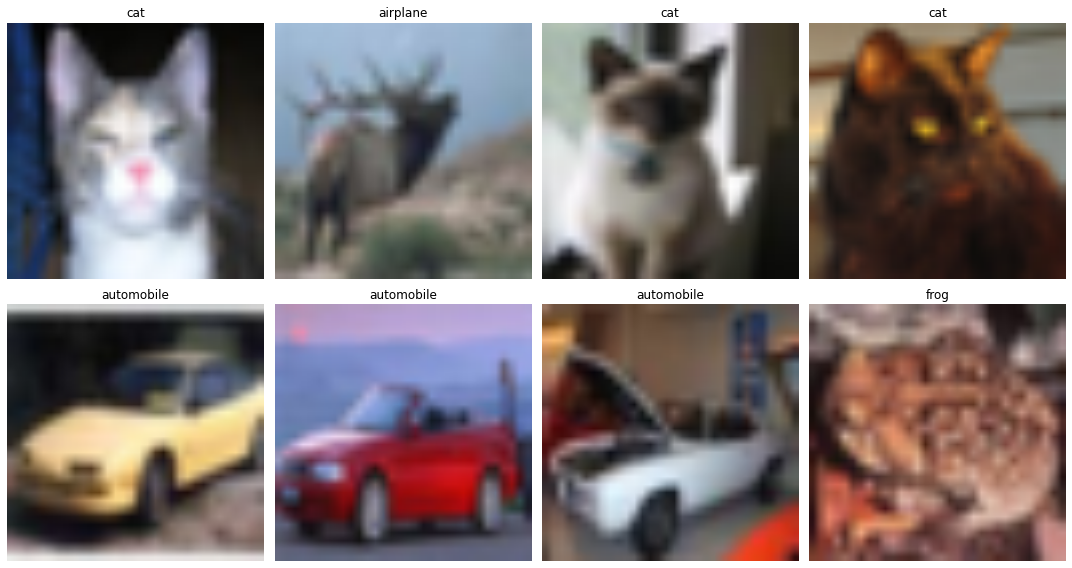

In [ ]:
## PGD

loss_fn  = torch.nn.CrossEntropyLoss()
num_steps = 10
step_size = 0.003
eps = 0.03     # 0.0, 6.1, 1./3
step_norm = 2
eps_norm = 2

## FGSM

fgsm_epsilon = 0.005

fig=plt.figure(figsize=(15,8))

labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# labels = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

def inference(model, dataset_sample, i):

    sample = dataset_sample[0]
    y = torch.tensor(dataset_sample[1], device=device).unsqueeze(0)
    x = sample.unsqueeze(0)
    x = x.to(device)

    x_adv = x
    
    # x_adv = projected_gradient_descent(model, x.to(device), y.to(device), LOSS_FN, NUM_STEPS, STEP_SIZE, STEP_NORM, EPS, EPS_NORM)
    # x_adv = FGSM(model, x.to(device), y, fgsm_epsilon)
    
    # atk = CarliniL0(model, num_labels = 10, num_channels = 3, image_size = 224, max_iterations=2, initial_const=1, largest_const=5)
    
    # atk = torchattacks.FGSM(model, eps=fgsm_epsilon)
    # atk = torchattacks.PGD(model, eps=eps, alpha=step_size, steps=num_steps)
    # atk = torchattacks.CW(model, c=100, kappa=0, steps=100, lr=0.01)
    # atk = torchattacks.DeepFool(model, steps=50, overshoot=0.2)
    # x_adv = atk(x, y)

    # x_adv = atk.attack(x, y)
    
    y_hat = model(x_adv)
    y_prob = F.softmax(y_hat, dim=1)
    _, predicted_labels = torch.max(y_prob, 1)

    sub = fig.add_subplot(2, 4, i+1)
    # plt.subplot(2, 5, i+1)
    plt.axis('off')
    sub.set_title(labels[predicted_labels.item()])
    plt.imshow(x_adv[0].detach().cpu().permute(1, 2, 0).numpy())
    plt.tight_layout()

indices = random.sample(range(0, len(wt_vgg_valid_dataset)), 8)
for i, index in enumerate(indices):
    inference(model, wt_vgg_valid_dataset[index], i)

In [ ]:
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.2023, 1/0.1994, 1/0.2010 ]),
                                transforms.Normalize(mean = [ -0.4914, -0.4822, -0.4465 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

P( orchids ) = 0.9984350800514221
P( shrew ) = 0.9305670857429504

P( forest ) = 0.9940609335899353
P( lizard ) = 0.725916862487793

P( pears ) = 0.9920095205307007
P( tractor ) = 0.9783915877342224



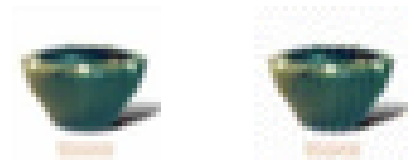

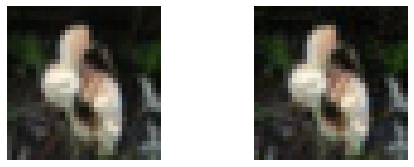

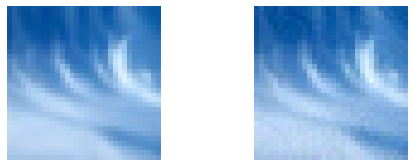

In [ ]:
## PGD

loss_fn  = torch.nn.CrossEntropyLoss()
num_steps = 10
step_size = 0.1
eps = 3./3     # 0.0, 6.1, 1./3
step_norm = 0.2
eps_norm = 'inf'

## FGSM

fgsm_epsilon = 0.02

# classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
classes = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

index = 6
i = 0
for x, y in wt_vgg_valid_loader:
    plt.figure(figsize=(7,7))
    plt.subplot(3, 2, i+1)
    plt.axis('off')
    plt.imshow(x[0].permute(1, 2, 0).numpy())
    i = i+1

    logits = model(x.to(device))
    probs = F.softmax(logits, dim=1)

    ind = torch.argmax(probs[0], dim=0)
    print('P(', classes[ind.item()], ') =', probs[0][ind].item())

    # x = train_dataset.data[index].unsqueeze(0).unsqueeze(0)
    # print(x)
    # y = train_dataset.train_labels[index]
    
    x_adv = projected_gradient_descent(model, x.to(device), y.to(device), LOSS_FN, NUM_STEPS, STEP_SIZE, STEP_NORM, EPS, EPS_NORM)
    # x_adv = FGSM(model, x.to(device), y.to(device), fgsm_epsilon)
    
    # atk = torchattacks.FGSM(model, eps=fgsm_epsilon)
    # atk = torchattacks.PGD(model, eps=eps, alpha=step_size, steps=num_steps)
    # x_adv = atk(x, y)

    x_adv = x_adv.detach()
    plt.subplot(3, 2, i+1)
    plt.axis('off')
    plt.imshow(x_adv[0].cpu().permute(1, 2, 0).numpy())
    plt.tight_layout()

    logits = model(x_adv.to(device))
    probs = F.softmax(logits, dim=1)
    ind = torch.argmax(probs[0], dim=0)
    print('P(', classes[ind.item()], ') =', probs[0][ind].item())

    print('')

    i = i+1
    if i == index:
        break

In [ ]:
path = '/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/VGG_16_wt_CIFAR10_pgd-0.03_trained_model.pkl'
model, optimizer, logs = load_model(path, model, optimizer)

Model loaded with logs {'epochs': 6, 'Train loss': [0.503010085093975, 0.24236576707839966, 0.16417750284522772, 0.10853300809204579, 0.0785197818852216, 0.057217892315275964], 'Valid loss': [0.2878072478175163, 0.2440381855905056, 0.24964217099547387, 0.21663878641724588, 0.20443291104733943, 0.27158904110193255], 'Train acc': [tensor(0.8245, device='cuda:0'), tensor(0.9174, device='cuda:0'), tensor(0.9423, device='cuda:0'), tensor(0.9625, device='cuda:0'), tensor(0.9731, device='cuda:0'), tensor(0.9799, device='cuda:0')], 'Valid acc': [tensor(0.8990, device='cuda:0'), tensor(0.9133, device='cuda:0'), tensor(0.9170, device='cuda:0'), tensor(0.9265, device='cuda:0'), tensor(0.9349, device='cuda:0'), tensor(0.9241, device='cuda:0')], 'ADV Valid acc': [], 'ADV Valid loss': []}
